In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('/Users/harshitapaila/Desktop/datasets/marketing_campaign.csv', header=0, sep=';')

# Data preprocessing and feature engineering
data['Age'] = 2014 - data['Year_Birth']
data['Spending'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

# Calculate customer seniority in months
last_date = date(2014, 10, 4)
data['Seniority'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%Y-%m-%d')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer') / 30

# Rename columns for better readability
data = data.rename(columns={
    'NumWebPurchases': 'Web',
    'NumCatalogPurchases': 'Catalog',
    'NumStorePurchases': 'Store'
})

# Replace values in Marital_Status and Education columns for better grouping
data['Marital_Status'] = data['Marital_Status'].replace({
    'Divorced': 'Alone',
    'Single': 'Alone',
    'Married': 'In couple',
    'Together': 'In couple',
    'Absurd': 'Alone',
    'Widow': 'Alone',
    'YOLO': 'Alone'
})

data['Education'] = data['Education'].replace({
    'Basic': 'Undergraduate',
    '2n Cycle': 'Undergraduate',
    'Graduation': 'Postgraduate',
    'Master': 'Postgraduate',
    'PhD': 'Postgraduate'
})

# Create new features: Children and Has_child
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_child'] = np.where(data.Children > 0, 'Has child', 'No child')
data['Children'].replace({
    3: '3 children',
    2: '2 children',
    1: '1 child',
    0: 'No child'
}, inplace=True)

# Rename product columns for clarity
data = data.rename(columns={
    'MntWines': 'Wines',
    'MntFruits': 'Fruits',
    'MntMeatProducts': 'Meat',
    'MntFishProducts': 'Fish',
    'MntSweetProducts': 'Sweets',
    'MntGoldProds': 'Gold'
})



In [4]:
# Select relevant columns for further analysis
data = data[['Age', 'Education', 'Marital_Status', 'Income', 'Spending', 'Seniority', 'Has_child', 'Children', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']]

# Fill missing values in numerical columns with column mean
data.fillna(data.mean(), inplace=True)

# Standardize and normalize data for clustering
scaler = StandardScaler()
dataset_temp = data[['Income', 'Seniority', 'Spending']]
X_std = scaler.fit_transform(dataset_temp)
X = normalize(X_std, norm='l2')



In [5]:
# Apply Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=4, covariance_type='spherical', max_iter=2000, random_state=5).fit(X)
labels = gmm.predict(X)
dataset_temp['Cluster'] = labels
dataset_temp = dataset_temp.replace({0: 'Stars', 1: 'Need attention', 2: 'High potential', 3: 'Leaky bucket'})
data = data.merge(dataset_temp.Cluster, left_index=True, right_index=True)

# Summary statistics of clusters
pd.options.display.float_format = "{:.0f}".format
summary = data[['Income', 'Spending', 'Seniority', 'Cluster']]
summary.set_index('Cluster', inplace=True)
summary = summary.groupby('Cluster').describe().transpose()
summary.head()

# 3D Scatter plot for clusters
PLOT = go.Figure()
for C in list(data.Cluster.unique()):
    PLOT.add_trace(go.Scatter3d(
        x=data[data.Cluster == C]['Income'],
        y=data[data.Cluster == C]['Seniority'],
        z=data[data.Cluster == C]['Spending'],
        mode='markers', marker_size=6, marker_line_width=1,
        name=str(C)
    ))
PLOT.update_traces(hovertemplate='Income: %{x} <br>Seniority: %{y} <br>Spending: %{z}')
PLOT.update_layout(width=800, height=800, autosize=True, showlegend=True,
                   scene=dict(xaxis=dict(title='Income', titlefont_color='black'),
                              yaxis=dict(title='Seniority', titlefont_color='black'),
                              zaxis=dict(title='Spending', titlefont_color='black')),
                   font=dict(family="Gilroy", color='black', size=12))
PLOT.show()


In [6]:

# Create segments for Age, Income, and Seniority
cut_labels_Age = ['Young', 'Adult', 'Mature', 'Senior']
cut_bins = [0, 30, 45, 65, 120]
data['Age_group'] = pd.cut(data['Age'], bins=cut_bins, labels=cut_labels_Age)

cut_labels_Income = ['Low income', 'Low to medium income', 'Medium to high income', 'High income']
data['Income_group'] = pd.qcut(data['Income'], q=4, labels=cut_labels_Income)

cut_labels_Seniority = ['New customers', 'Discovering customers', 'Experienced customers', 'Old customers']
data['Seniority_group'] = pd.qcut(data['Seniority'], q=4, labels=cut_labels_Seniority)

data = data.drop(columns=['Age', 'Income', 'Seniority'])



In [7]:
# Create segments for product consumption
cut_labels = ['Low consumer', 'Frequent consumer', 'Biggest consumer']
data['Wines_segment'] = pd.qcut(data['Wines'][data['Wines'] > 0], q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Fruits_segment'] = pd.qcut(data['Fruits'][data['Fruits'] > 0], q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Meat_segment'] = pd.qcut(data['Meat'][data['Meat'] > 0], q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Fish_segment'] = pd.qcut(data['Fish'][data['Fish'] > 0], q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Sweets_segment'] = pd.qcut(data['Sweets'][data['Sweets'] > 0], q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Gold_segment'] = pd.qcut(data['Gold'][data['Gold'] > 0], q=[0, .25, .75, 1], labels=cut_labels).astype("object")

data.replace(np.nan, "Non consumer", inplace=True)
data = data.drop(columns=['Spending', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold'])
data = data.astype(object)



In [11]:
# Association Rules Analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 999)
pd.options.display.float_format = "{:.3f}".format
association = data.copy()
df = pd.get_dummies(association)
min_support = 0.08
max_len = 10
frequent_items = apriori(df, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

product = 'Wines'
segment = 'Biggest consumer'
target = f"{{'{product}_segment_{segment}'}}"
results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
results_personnal_care.head()



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4890,"(Cluster_Stars, Income_group_High income)",(Wines_segment_Biggest consumer),0.121,0.248,0.084,0.697,2.810,0.054,2.485,0.733
4902,"(Cluster_Stars, Seniority_group_Old customers)",(Wines_segment_Biggest consumer),0.121,0.248,0.084,0.695,2.799,0.054,2.464,0.732
9530,"(Cluster_Stars, Meat_segment_Biggest consumer, Education_Postgraduate)",(Wines_segment_Biggest consumer),0.121,0.248,0.081,0.665,2.681,0.051,2.247,0.714
6188,"(Cluster_Stars, Marital_Status_In couple, Education_Postgraduate)",(Wines_segment_Biggest consumer),0.137,0.248,0.089,0.650,2.620,0.055,2.150,0.716
1514,"(Cluster_Stars, Education_Postgraduate)",(Wines_segment_Biggest consumer),0.216,0.248,0.140,0.649,2.614,0.087,2.140,0.788


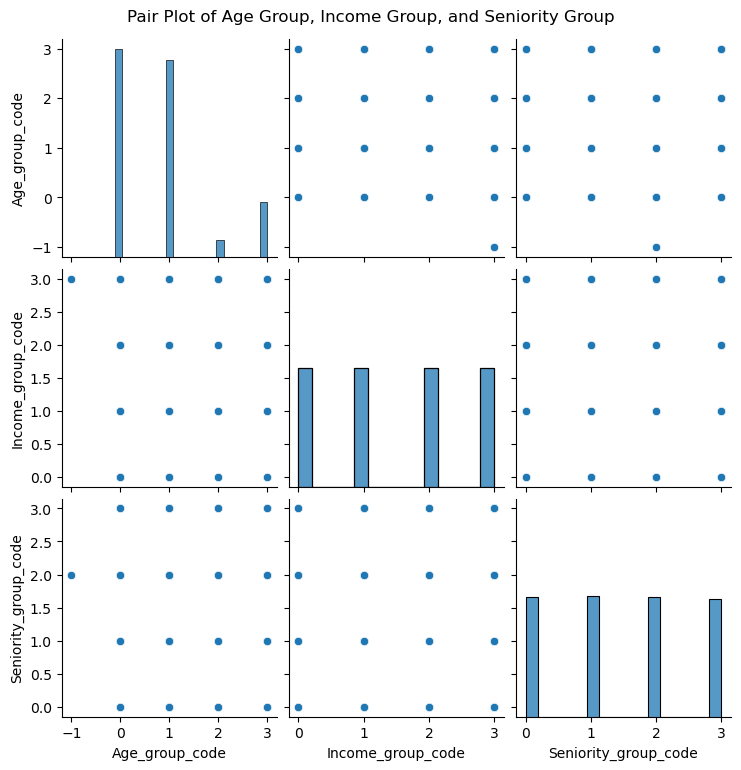

In [15]:
# Convert columns to 'category' dtype
data['Age_group'] = data['Age_group'].astype('category')
data['Income_group'] = data['Income_group'].astype('category')
data['Seniority_group'] = data['Seniority_group'].astype('category')

# Convert categorical columns to numerical codes
data['Age_group_code'] = data['Age_group'].cat.codes
data['Income_group_code'] = data['Income_group'].cat.codes
data['Seniority_group_code'] = data['Seniority_group'].cat.codes

# Visualization 1: Pair Plot with numerical codes
sns.pairplot(data[['Age_group_code', 'Income_group_code', 'Seniority_group_code']])
plt.suptitle("Pair Plot of Age Group, Income Group, and Seniority Group", y=1.02)
plt.show()



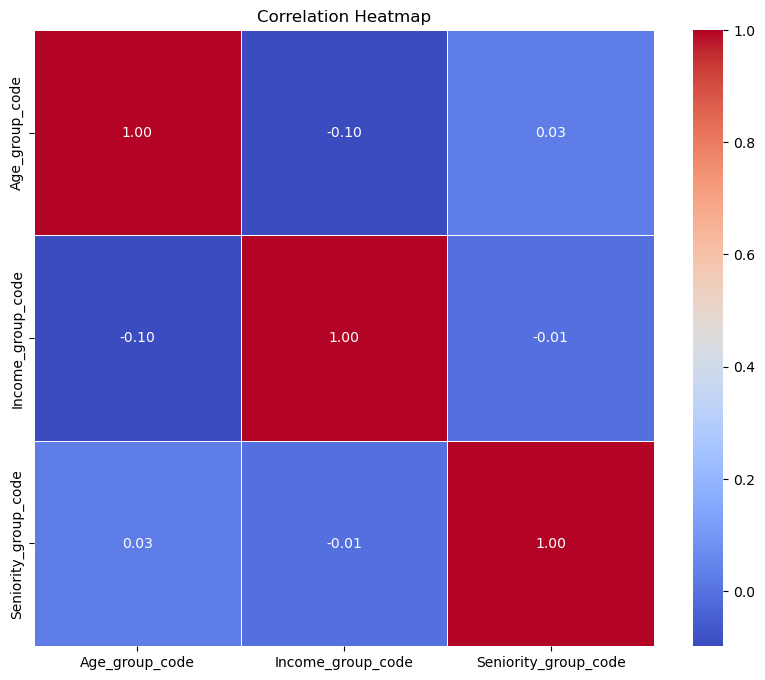

In [16]:
# Visualization 2: Correlation heatmap
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



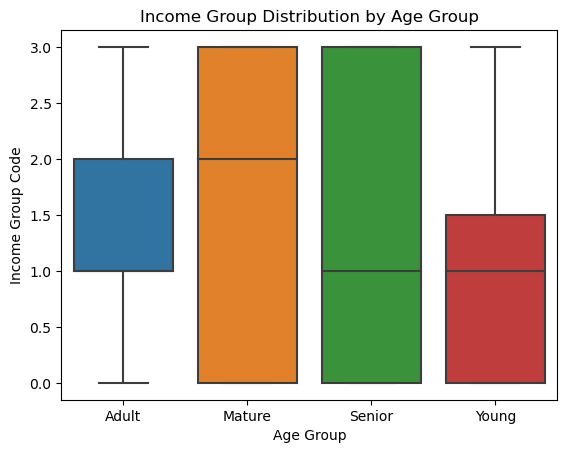

In [18]:
# Convert `Income_group` to numerical codes
data['Income_group_code'] = data['Income_group'].astype('category').cat.codes

# Visualization 3: Boxplot using numerical codes for Income Group
sns.boxplot(x='Age_group', y='Income_group_code', data=data)
plt.title('Income Group Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Income Group Code')
plt.show()


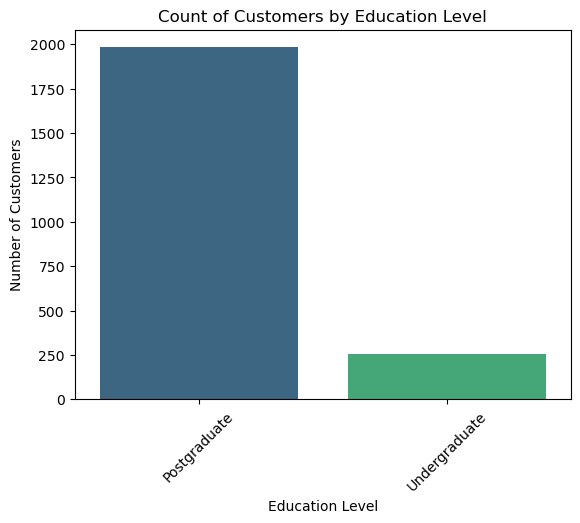

In [24]:
# Visualization 4: Countplot of Customers by Education Level
sns.countplot(x='Education', data=data, palette='viridis')
plt.title('Count of Customers by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

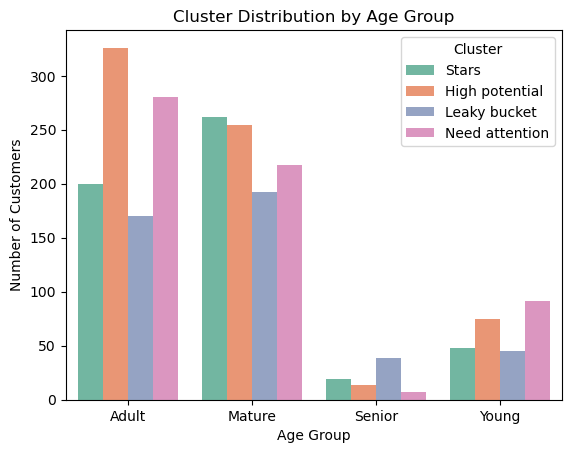

In [25]:
# Visualization 5: Cluster distribution by Age Group
sns.countplot(x='Age_group', hue='Cluster', data=data, palette='Set2')
plt.title('Cluster Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.show()

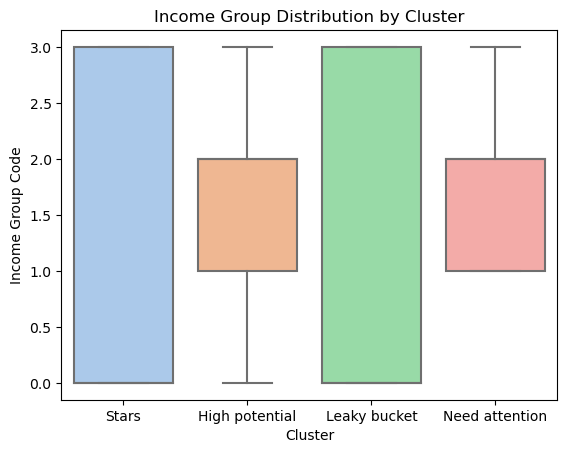

In [28]:
# Convert 'Income_group' to numerical codes
data['Income_group_code'] = data['Income_group'].astype('category').cat.codes

# Visualization 6: Boxplot using 'Income_group_code' by Cluster
sns.boxplot(x='Cluster', y='Income_group_code', data=data, palette='pastel')
plt.title('Income Group Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Income Group Code')
plt.show()


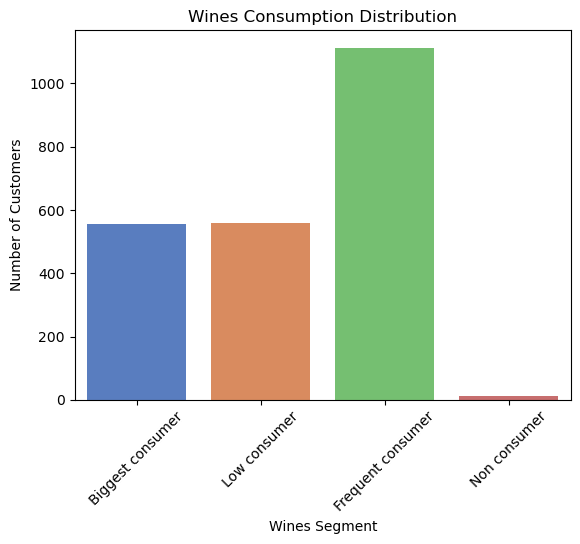

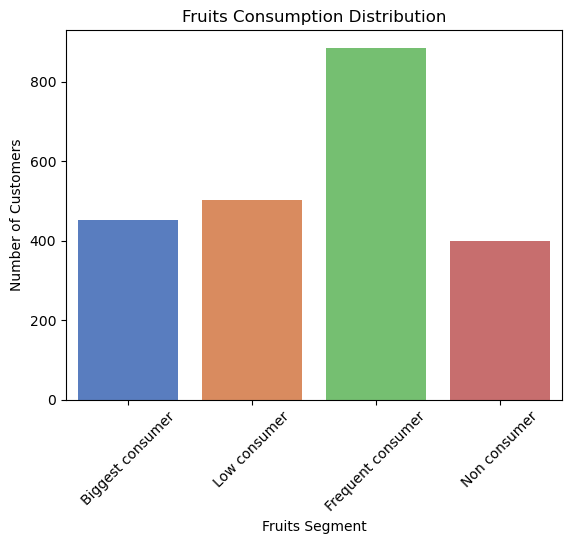

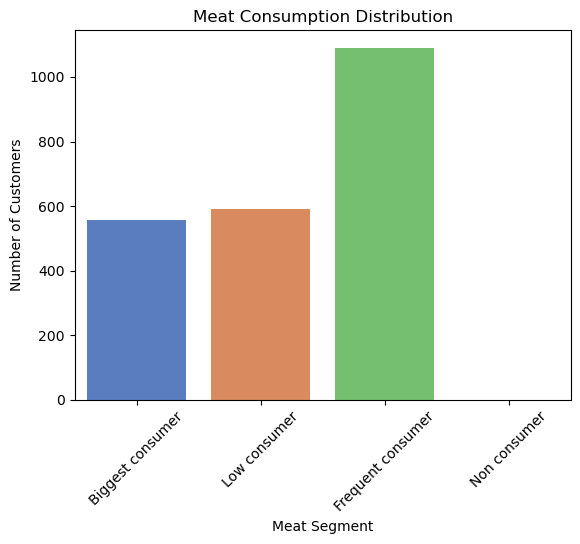

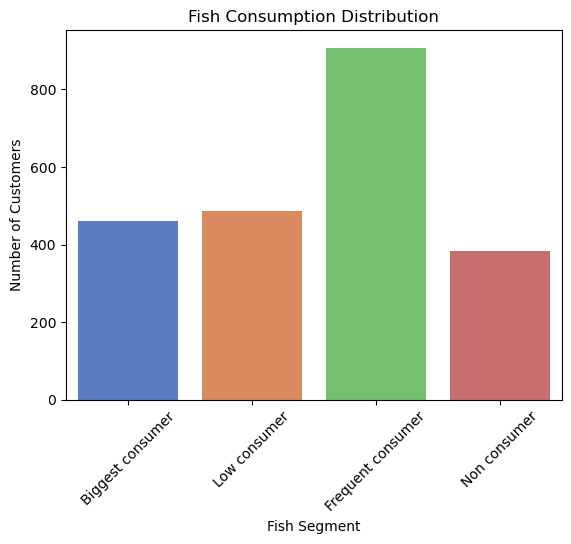

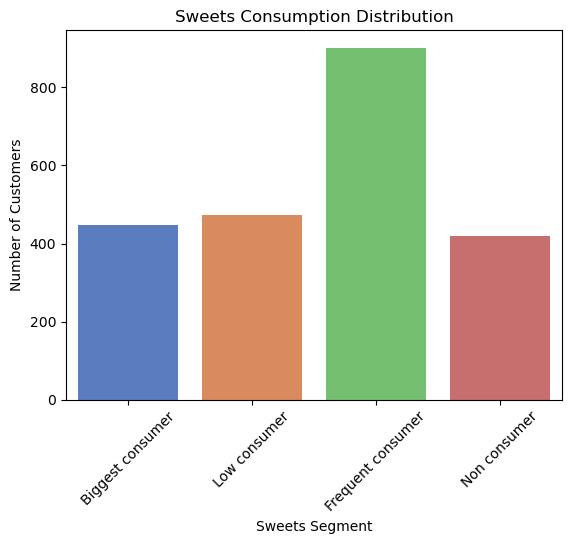

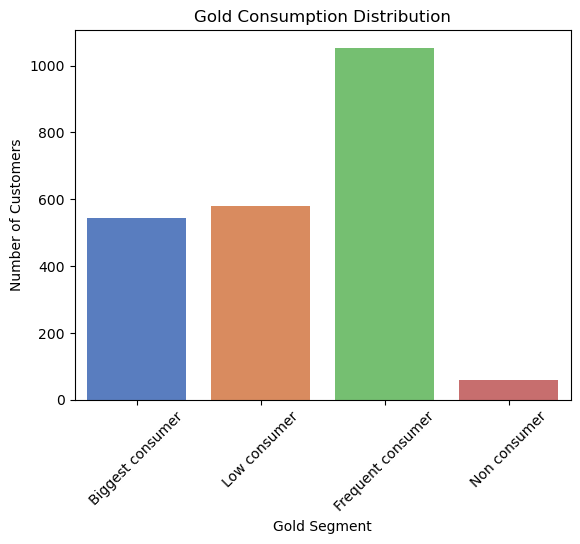

In [29]:
# Visualization 7: Product Consumption Distribution
products = ['Wines_segment', 'Fruits_segment', 'Meat_segment', 'Fish_segment', 'Sweets_segment', 'Gold_segment']
for product in products:
    sns.countplot(x=product, data=data, palette='muted')
    plt.title(f'{product.replace("_segment", "").capitalize()} Consumption Distribution')
    plt.xlabel(f'{product.replace("_segment", "").capitalize()} Segment')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.show()
